# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import torchvision

import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

### Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
model = ConvNet()
model=model.cuda()

### Optimizer

In [7]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

In [8]:
criterion = nn.L1Loss()

In [9]:
def train_batch(model, image, target):
    target = F.one_hot(target, num_classes=10)
    target = target.view(-1, 10)
    output =  model(image)
    loss = criterion(output, target)
    return output, loss

def test_batch(model, image, target):
    target = F.one_hot(target, num_classes=10)
    target = target.view(-1, 10)
    output =  model(image)
    loss = criterion(output, target)
    return output, loss

### Model Training

In [10]:
training_loss=[] 
training_acc=[] 
testing_loss=[] 
testing_acc=[] 
train_preds=[] 
train_targets=[] 
test_preds=[] 
test_targets=[] 
train_f1_scores=[]
test_f1_scores=[] 
layer_gradients = [[] for _ in range(len(list(model.parameters())))]


for epoch in range(NUM_EPOCHS): 
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)
        
        train_preds.extend(preds.cpu().tolist())
        train_targets.extend(target.cpu().tolist())

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        for i, (name, param) in enumerate(model.named_parameters()):
            if param.grad is not None:
                layer_gradients[i].append(param.grad.abs().mean().item())
           
    
        optimizer.step()
        optimizer.zero_grad()
    train_recall = recall_score(train_targets, train_preds, average='weighted')
    train_f1 = f1_score(train_targets, train_preds, average='weighted')
    train_f1_scores.append(train_f1)
    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    print(f'Train Recall: {train_recall:.4f} F1 Score: {train_f1:.4f}')
    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())
    train_f1 = f1_score(train_targets, train_preds, average='weighted')

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().tolist())
            test_targets.extend(target.cpu().tolist())
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
        test_recall = recall_score(test_targets, test_preds, average='weighted')
        test_f1 = f1_score(test_targets, test_preds, average='weighted')
        test_f1_scores.append(test_f1)
        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        print(f'Test Recall: {test_recall:.4f} F1 Score: {test_f1:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))


Epoch: 1/30 Train Loss: 0.0009 Acc: 0.0992
Train Recall: 0.0992 F1 Score: 0.0957
Begin test......
Test Loss: 0.0009 Acc: 0.1000
Test Recall: 0.1000 F1 Score: 0.0182
Epoch: 2/30 Train Loss: 0.0009 Acc: 0.1005
Train Recall: 0.0998 F1 Score: 0.0963
Begin test......
Test Loss: 0.0009 Acc: 0.1000
Test Recall: 0.1000 F1 Score: 0.0333
Epoch: 3/30 Train Loss: 0.0009 Acc: 0.0998
Train Recall: 0.0998 F1 Score: 0.0980
Begin test......
Test Loss: 0.0009 Acc: 0.1000
Test Recall: 0.1000 F1 Score: 0.0462
Epoch: 4/30 Train Loss: 0.0009 Acc: 0.0989
Train Recall: 0.0996 F1 Score: 0.0984
Begin test......
Test Loss: 0.0009 Acc: 0.1000
Test Recall: 0.1000 F1 Score: 0.0452
Epoch: 5/30 Train Loss: 0.0009 Acc: 0.0994
Train Recall: 0.0996 F1 Score: 0.0986
Begin test......
Test Loss: 0.0009 Acc: 0.1000
Test Recall: 0.1000 F1 Score: 0.0560
Epoch: 6/30 Train Loss: 0.0008 Acc: 0.1002
Train Recall: 0.0997 F1 Score: 0.0990
Begin test......
Test Loss: 0.0008 Acc: 0.0999
Test Recall: 0.1000 F1 Score: 0.0558
Epoch: 7/3

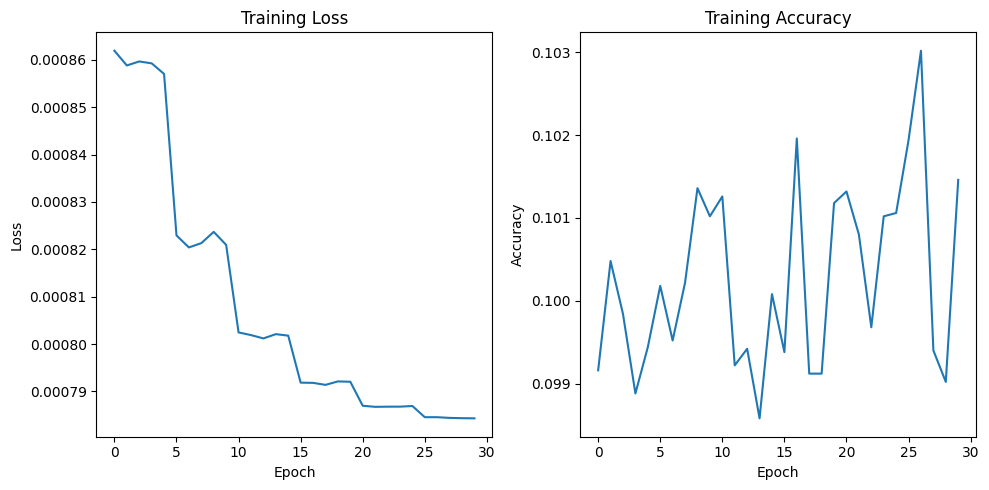

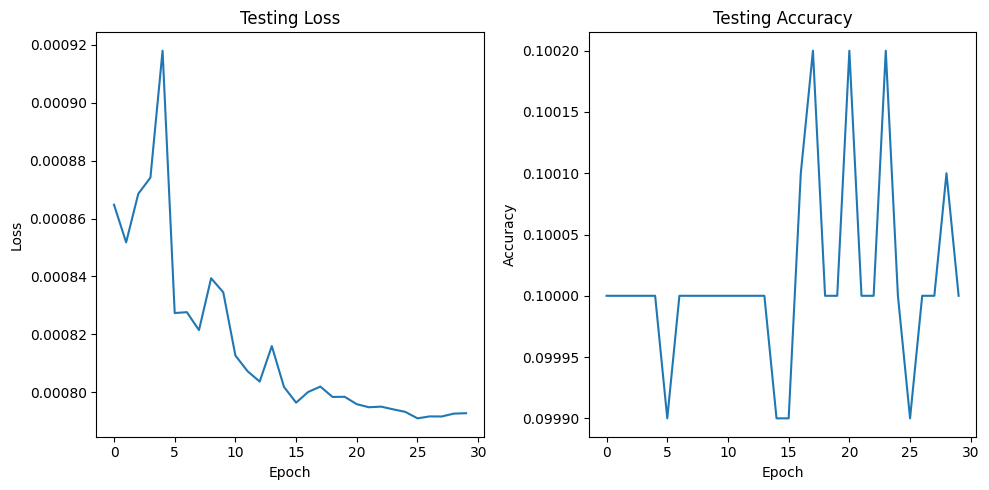

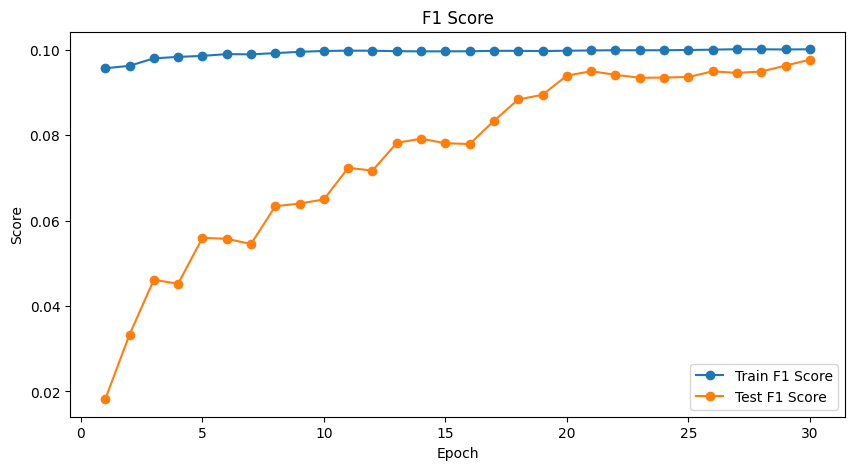

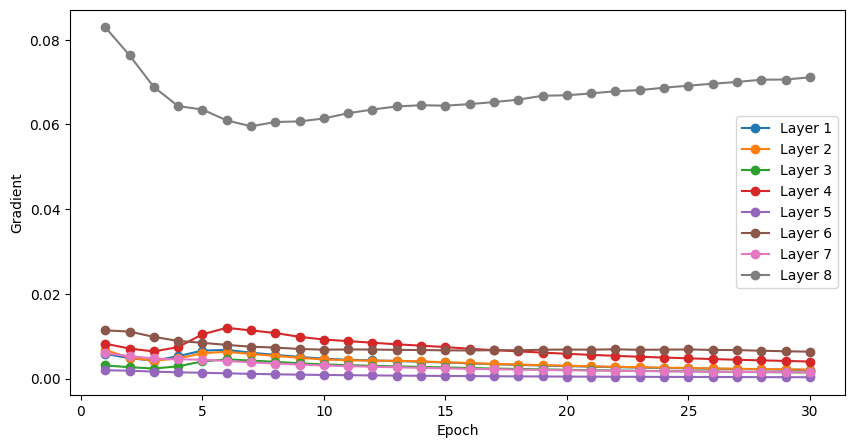

In [11]:
# 可视化训练损失和准确率
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(training_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(training_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.tight_layout()
plt.show()

# 可视化测试损失和准确率
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(testing_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Testing Loss')

plt.subplot(1, 2, 2)
plt.plot(testing_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_f1_scores, marker='o', label='Train F1 Score')

plt.plot(range(1, NUM_EPOCHS + 1), test_f1_scores, marker='o', label='Test F1 Score')

plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('F1 Score')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
for i, gradients in enumerate(layer_gradients):
    x = range(1, NUM_EPOCHS + 1)
    y = [np.mean(gradients[:epoch]) for epoch in x]
    plt.plot(x, y, marker='o', label=f'Layer {i+1}')

plt.xlabel('Epoch')
plt.ylabel('Gradient')
plt.legend()
plt.show()




In [12]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.cross_entropy = nn.CrossEntropyLoss(reduction='none')

    def forward(self, input, target):
        num_classes = torch.max(target).item() + 1
        target = F.one_hot(target, num_classes=num_classes)
        target = target.view(-1, num_classes)
        log_prob = torch.log_softmax(input, dim=1)
        prob = torch.exp(log_prob)
        focal_weight = (1 - prob) ** self.gamma
        target_labels = torch.argmax(target, dim=1)
        ce_loss = self.cross_entropy(input, target_labels)
        focal_loss = focal_weight * ce_loss.mean()
        return focal_loss.mean()

In [13]:
loss_functions = {
'Focal_0.5': FocalLoss(gamma=0.5),
'Focal_2': FocalLoss(gamma=2)
}

In [14]:
def train_batch(model, image, target, criterion):
    target = target.squeeze().long()
    output = model(image)
    loss = criterion(output, target)
    return output, loss

def test_batch(model, image, target, criterion):
    target_labels = target.squeeze().long()
    output = model(image)
    loss = criterion(output, target_labels)
    loss = criterion(output, target)
    return output, loss

In [15]:
training_loss = [[] for _ in range(len(loss_functions))]
training_acc = [[] for _ in range(len(loss_functions))]
testing_loss = [[] for _ in range(len(loss_functions))]
testing_acc = [[] for _ in range(len(loss_functions))]
train_preds = [[] for _ in range(len(loss_functions))]
train_targets = [[] for _ in range(len(loss_functions))]
test_preds = [[] for _ in range(len(loss_functions))]
test_targets = [[] for _ in range(len(loss_functions))]
train_f1_scores = [[] for _ in range(len(loss_functions))]
test_f1_scores = [[] for _ in range(len(loss_functions))]
layer_gradients = [[[] for _ in range(len(list(model.parameters())))] for _ in range(len(loss_functions))]
i=-1
for idx, loss_name in enumerate(loss_functions.keys()):
 
    model = ConvNet()
    model = model.cuda()  # 将模型移动到CUDA设备上
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
    
    loss_function = loss_functions[loss_name]
    i+=1
    for epoch in range(NUM_EPOCHS):
        model.train()
        torch.cuda.empty_cache()
        running_cls_loss = 0.0
        running_cls_corrects = 0


        for batch_idx, (image, target) in enumerate(train_dataloader):

            image = image.to(device)
            target = target.to(device)

            # train model
            outputs, loss = train_batch(model, image, target, loss_function)
            _, preds = torch.max(outputs, 1)

            train_preds[i].extend(preds.cpu().tolist())
            train_targets[i].extend(target.cpu().tolist())

            loss_data = loss.data.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
            running_cls_loss += loss.item()
            running_cls_corrects += torch.sum(preds == target.data)

            loss.backward()
            for j, (name, param) in enumerate(model.named_parameters()):
                if param.grad is not None:
                    layer_gradients[i][j].append(param.grad.abs().mean().item())

            optimizer.step()
            optimizer.zero_grad()

        train_recall = recall_score(train_targets[i], train_preds[i], average='weighted')
        train_f1 = f1_score(train_targets[i], train_preds[i], average='weighted')
        train_f1_scores[i].append(train_f1)
        epoch_loss = running_cls_loss / len(train_set)
        epoch_acc = running_cls_corrects.double() / len(train_set)

        print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Train Recall: {train_recall:.4f} F1 Score: {train_f1:.4f}')
        training_loss[i].append(epoch_loss)
        training_acc[i].append(epoch_acc.cpu().detach().numpy())
        train_f1 = f1_score(train_targets[i], train_preds[i], average='weighted')

        # change learning rate
        scheduler.step()

        ##########################
        ### Testing
        ##########################
        # eval model during training or in the last epoch
        if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch + 1) == NUM_EPOCHS:
            print('Begin test......')
            model.eval()

            val_loss = 0.0
            val_corrects = 0

            for batch_idx, (image, target) in enumerate(test_dataloader):

                image = image.to(device)
                target = target.to(device)

                # test model
                outputs, loss = test_batch(model, image, target, loss_function)
                _, preds = torch.max(outputs, 1)
                test_preds[i].extend(preds.cpu().tolist())
                test_targets[i].extend(target.cpu().tolist())

                val_loss += loss.item()
                val_corrects += torch.sum(preds == target.data)
            test_recall = recall_score(test_targets[i], test_preds[i], average='weighted')
            test_f1 = f1_score(test_targets[i], test_preds[i], average='weighted')
            test_f1_scores[i].append(test_f1)
            val_loss = val_loss / len(test_set)
            val_acc = val_corrects.double() / len(test_set)
            print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
            print(f'Test Recall: {test_recall:.4f} F1 Score: {test_f1:.4f}')
            testing_loss[i].append(val_loss)
            testing_acc[i].append(val_acc.cpu().detach().numpy())

            # save the model in last epoch
            if (epoch + 1) == NUM_EPOCHS:

                state = {
                    'state_dict': model.state_dict(),
                    'acc': epoch_acc,
                    'epoch': (epoch + 1),
                }

                # check the dir
                if not os.path.exists(SAVE_DIR):
                    os.makedirs(SAVE_DIR)

                # save the state
                torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0146 Acc: 0.2630
Train Recall: 0.2630 F1 Score: 0.2577
Begin test......
Test Loss: 0.0133 Acc: 0.3444
Test Recall: 0.3444 F1 Score: 0.3266
Epoch: 2/30 Train Loss: 0.0131 Acc: 0.3445
Train Recall: 0.3037 F1 Score: 0.2985
Begin test......
Test Loss: 0.0124 Acc: 0.3882
Test Recall: 0.3663 F1 Score: 0.3507
Epoch: 3/30 Train Loss: 0.0128 Acc: 0.3604
Train Recall: 0.3226 F1 Score: 0.3175
Begin test......
Test Loss: 0.0125 Acc: 0.3905
Test Recall: 0.3744 F1 Score: 0.3626
Epoch: 4/30 Train Loss: 0.0126 Acc: 0.3708
Train Recall: 0.3347 F1 Score: 0.3297
Begin test......
Test Loss: 0.0120 Acc: 0.4149
Test Recall: 0.3845 F1 Score: 0.3753
Epoch: 5/30 Train Loss: 0.0126 Acc: 0.3778
Train Recall: 0.3433 F1 Score: 0.3385
Begin test......
Test Loss: 0.0123 Acc: 0.3915
Test Recall: 0.3859 F1 Score: 0.3788
Epoch: 6/30 Train Loss: 0.0118 Acc: 0.4151
Train Recall: 0.3553 F1 Score: 0.3506
Begin test......
Test Loss: 0.0113 Acc: 0.4441
Test Recall: 0.3956 F1 Score: 0.3894
Epoch: 7/3

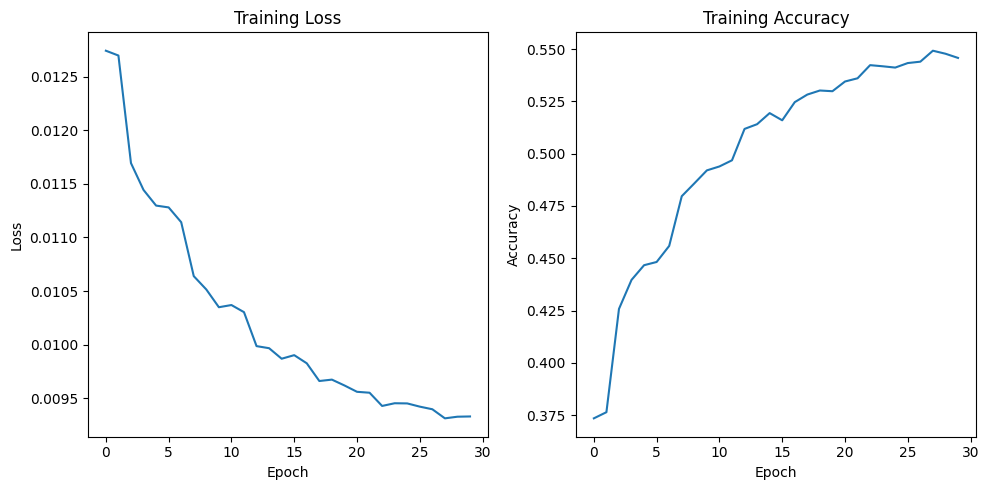

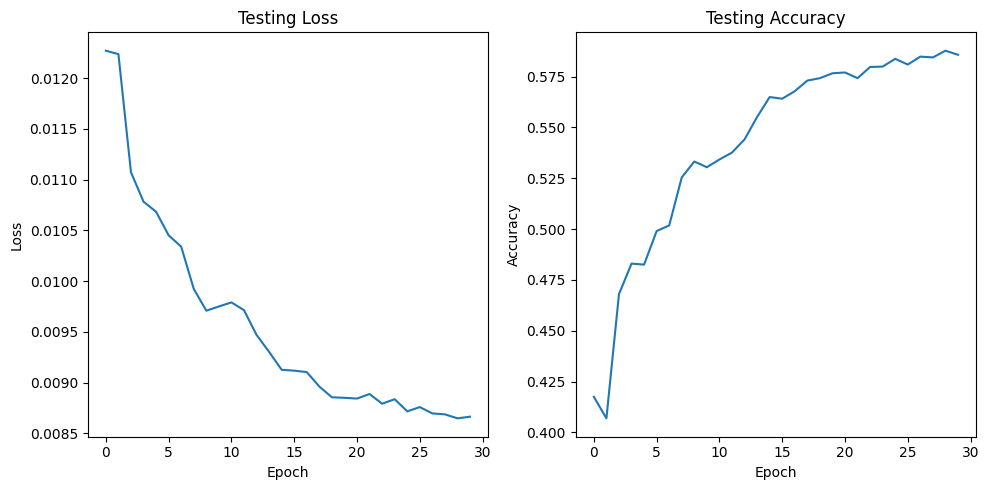

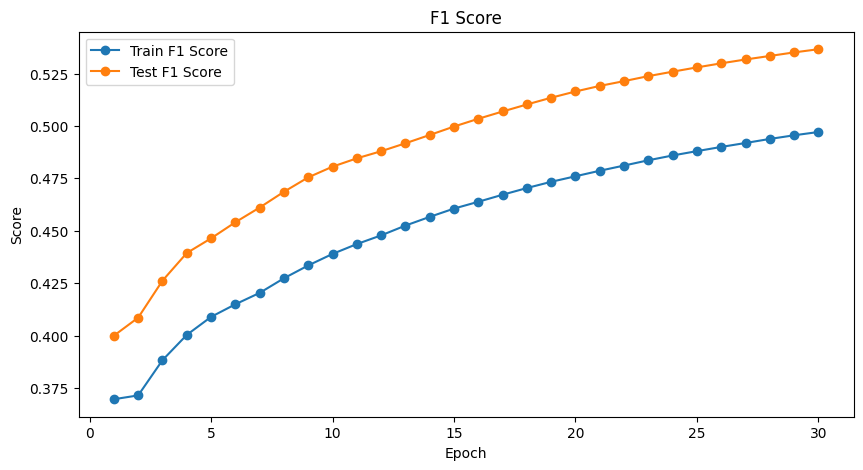

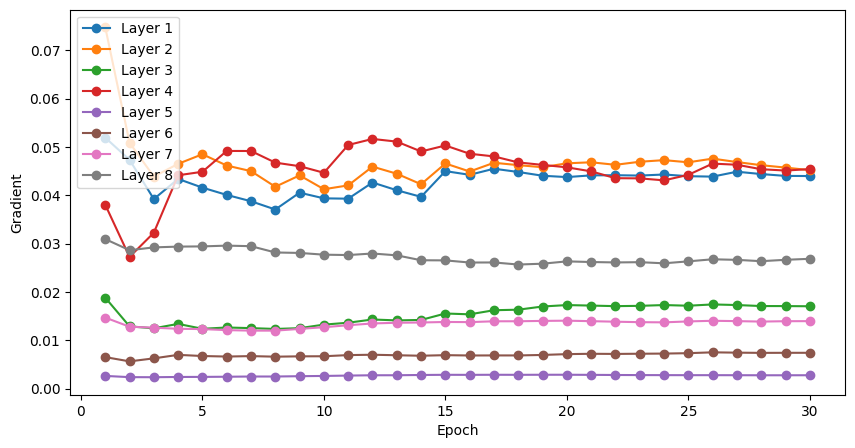

In [137]:
   
    # 可视化训练损失和准确率
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(training_loss[0])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')

    plt.subplot(1, 2, 2)
    plt.plot(training_acc[0])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')

    plt.tight_layout()
    plt.show()

    # 可视化测试损失和准确率
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(testing_loss[0])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Testing Loss')

    plt.subplot(1, 2, 2)
    plt.plot(testing_acc[0])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Testing Accuracy')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, NUM_EPOCHS + 1), train_f1_scores[0], marker='o', label='Train F1 Score')

    plt.plot(range(1, NUM_EPOCHS + 1), test_f1_scores[0], marker='o', label='Test F1 Score')

    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('F1 Score')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    for i, gradients in enumerate(layer_gradients[0]):
        x = range(1, NUM_EPOCHS + 1)
        y = [np.mean(gradients[:epoch]) for epoch in x]
        plt.plot(x, y, marker='o', label=f'Layer {i+1}')

    plt.xlabel('Epoch')
    plt.ylabel('Gradient')
    plt.legend()
    plt.show()

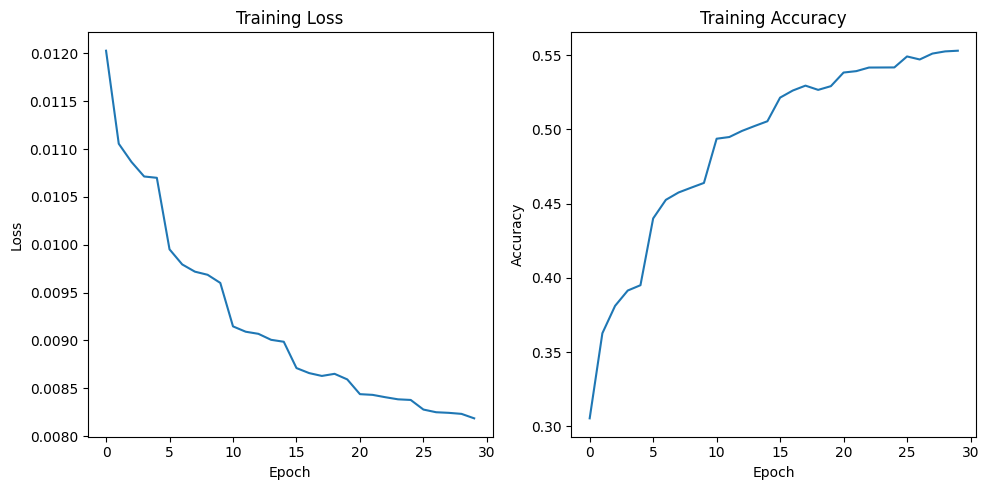

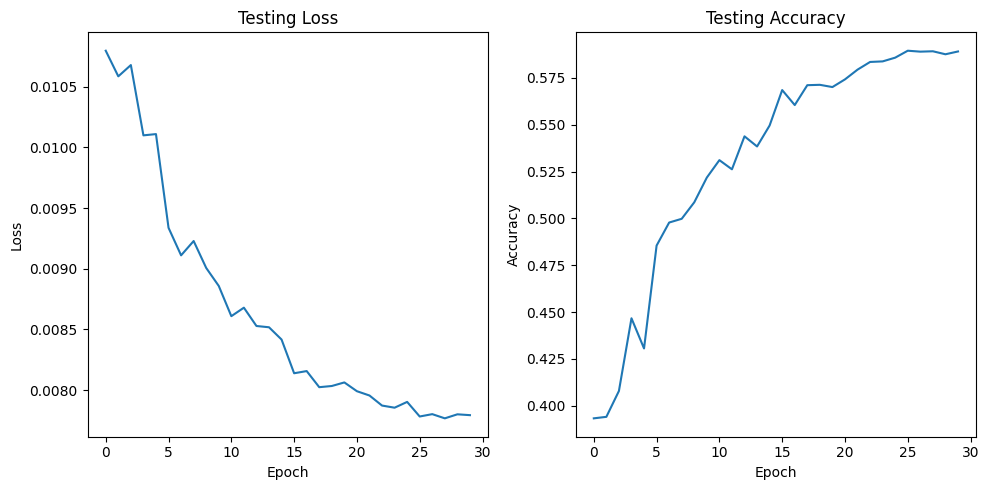

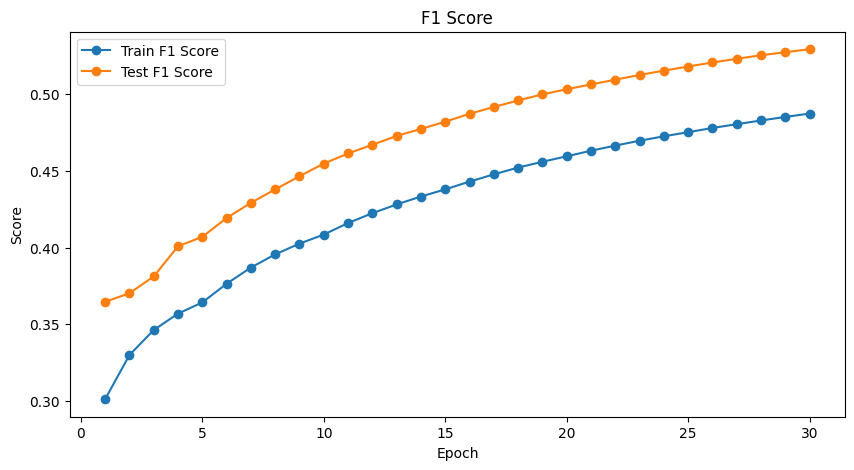

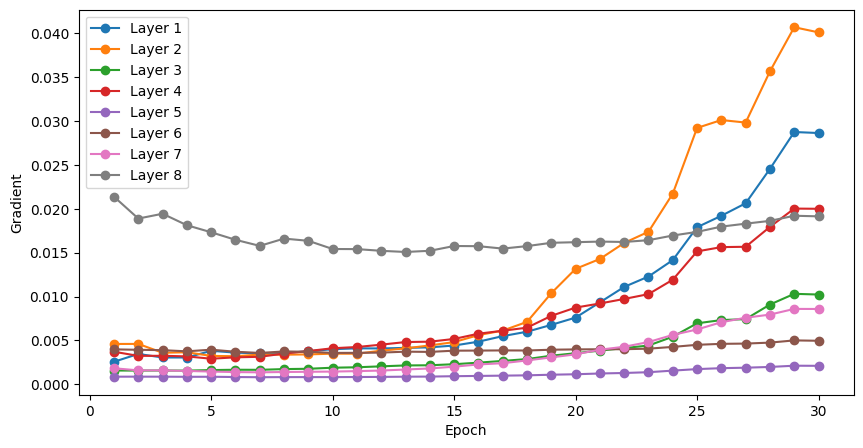

In [28]:
   
    # 可视化训练损失和准确率
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(training_loss[1])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')

    plt.subplot(1, 2, 2)
    plt.plot(training_acc[1])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')

    plt.tight_layout()
    plt.show()

    # 可视化测试损失和准确率
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(testing_loss[1])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Testing Loss')

    plt.subplot(1, 2, 2)
    plt.plot(testing_acc[1])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Testing Accuracy')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, NUM_EPOCHS + 1), train_f1_scores[1], marker='o', label='Train F1 Score')

    plt.plot(range(1, NUM_EPOCHS + 1), test_f1_scores[1], marker='o', label='Test F1 Score')

    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('F1 Score')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    for i, gradients in enumerate(layer_gradients[1]):
        x = range(1, NUM_EPOCHS + 1)
        y = [np.mean(gradients[:epoch]) for epoch in x]
        plt.plot(x, y, marker='o', label=f'Layer {i+1}')

    plt.xlabel('Epoch')
    plt.ylabel('Gradient')
    plt.legend()
    plt.show()


In [30]:
criterion =nn.CrossEntropyLoss()

In [31]:
def train_batch(model, image, target):
    output =  model(image)
    loss = criterion(output, target)
    return output, loss

In [32]:

def test_batch(model, image, target):
    output =  model(image)
    loss = criterion(output, target)
    return output, loss

In [33]:
CRtraining_loss = []
CRtraining_acc = []
CRtesting_loss = []
CRtesting_acc = []
CRtrain_preds = []
CRtrain_targets = []
CRtest_preds = []
CRtest_targets = []
CRtrain_f1_scores = []
CRtest_f1_scores = []
CRlayer_gradients = [[] for _ in range(len(list(model.parameters())))]
model = ConvNet()
model = model.cuda()  # 将模型移动到CUDA设备上
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):
        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        CRtrain_preds.extend(preds.cpu().tolist())
        CRtrain_targets.extend(target.cpu().tolist())

        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        for i, (name, param) in enumerate(model.named_parameters()):
            if param.grad is not None:
                CRlayer_gradients[i].append(param.grad.abs().mean().item())

        optimizer.step()
        optimizer.zero_grad()

    CRtrain_recall = recall_score(CRtrain_targets, CRtrain_preds, average='weighted')
    CRtrain_f1 = f1_score(CRtrain_targets, CRtrain_preds, average='weighted')
    CRtrain_f1_scores.append(CRtrain_f1)
    CRepoch_loss = running_cls_loss / len(train_set)
    CRepoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {CRepoch_loss:.4f} Acc: {CRepoch_acc:.4f}')
    print(f'Train Recall: {CRtrain_recall:.4f} F1 Score: {CRtrain_f1:.4f}')
    CRtraining_loss.append(CRepoch_loss)
    CRtraining_acc.append(CRepoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()

    ##########################
    ### Testing
    ##########################
    # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch + 1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()

        CRval_loss = 0.0
        CRval_corrects = 0
        CRtest_preds = []
        CRtest_targets = []

        for batch_idx, (image, target) in enumerate(test_dataloader):
            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            CRtest_preds.extend(preds.cpu().tolist())
            CRtest_targets.extend(target.cpu().tolist())

            CRval_loss += loss.item()
            CRval_corrects += torch.sum(preds == target.data)

        CRtest_recall = recall_score(CRtest_targets, CRtest_preds, average='weighted')
        CRtest_f1 = f1_score(CRtest_targets, CRtest_preds, average='weighted')
        CRtest_f1_scores.append(CRtest_f1)
        CRval_loss = CRval_loss / len(test_set)
        CRval_acc = CRval_corrects.double() / len(test_set)
        print(f'Test Loss: {CRval_loss:.4f} Acc: {CRval_acc:.4f}')
        print(f'Test Recall: {CRtest_recall:.4f} F1 Score: {CRtest_f1:.4f}')
        CRtesting_loss.append(CRval_loss)
        CRtesting_acc.append(CRval_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch + 1) == NUM_EPOCHS:
            state = {
                'state_dict': model.state_dict(),
                'acc': epoch_acc,
                'epoch': (epoch + 1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch + 1))))

Epoch: 1/30 Train Loss: 0.0166 Acc: 0.1921
Train Recall: 0.1921 F1 Score: 0.1796
Begin test......
Test Loss: 0.0151 Acc: 0.2766
Test Recall: 0.2766 F1 Score: 0.2395
Epoch: 2/30 Train Loss: 0.0148 Acc: 0.2856
Train Recall: 0.2388 F1 Score: 0.2250
Begin test......
Test Loss: 0.0144 Acc: 0.3172
Test Recall: 0.3172 F1 Score: 0.2738
Epoch: 3/30 Train Loss: 0.0145 Acc: 0.3007
Train Recall: 0.2595 F1 Score: 0.2466
Begin test......
Test Loss: 0.0142 Acc: 0.3191
Test Recall: 0.3191 F1 Score: 0.2984
Epoch: 4/30 Train Loss: 0.0142 Acc: 0.3127
Train Recall: 0.2728 F1 Score: 0.2607
Begin test......
Test Loss: 0.0143 Acc: 0.3478
Test Recall: 0.3478 F1 Score: 0.3245
Epoch: 5/30 Train Loss: 0.0140 Acc: 0.3265
Train Recall: 0.2835 F1 Score: 0.2721
Begin test......
Test Loss: 0.0135 Acc: 0.3648
Test Recall: 0.3648 F1 Score: 0.3466
Epoch: 6/30 Train Loss: 0.0133 Acc: 0.3620
Train Recall: 0.2966 F1 Score: 0.2858
Begin test......
Test Loss: 0.0128 Acc: 0.3923
Test Recall: 0.3923 F1 Score: 0.3621
Epoch: 7/3

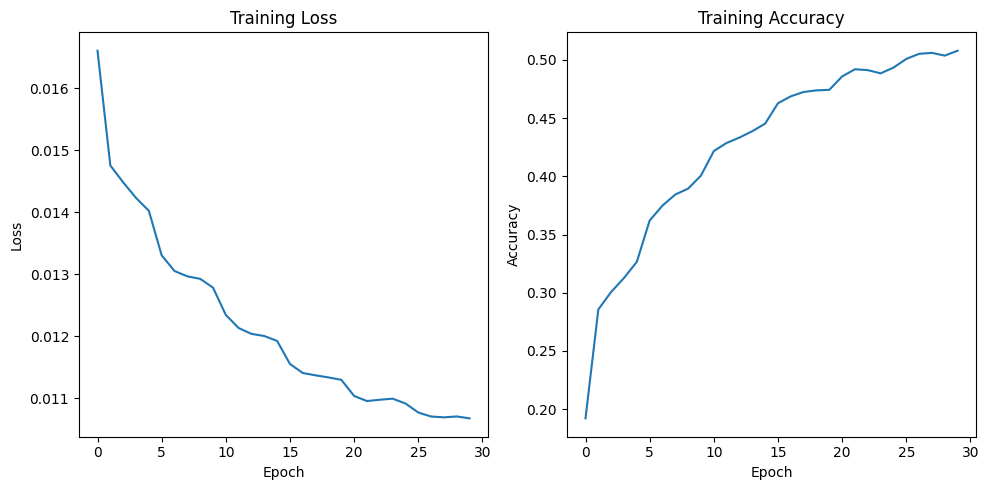

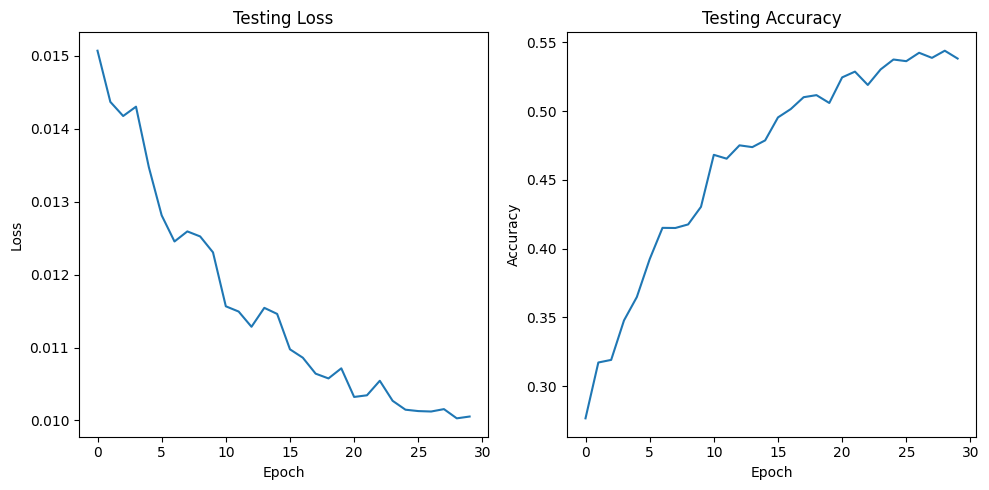

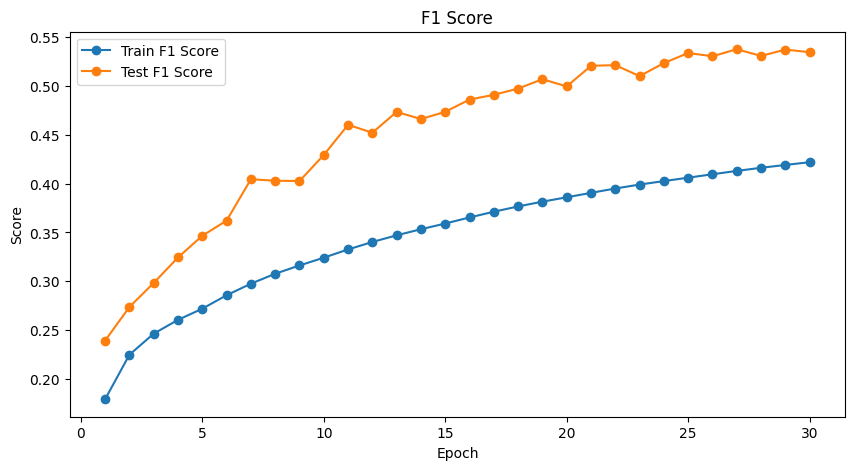

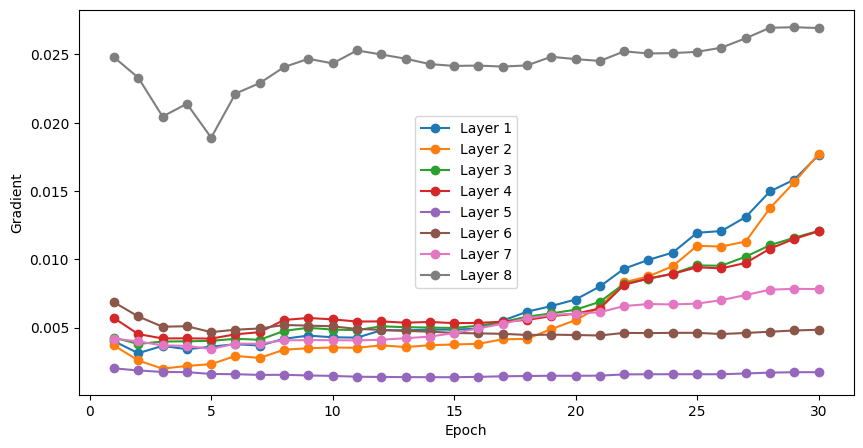

In [34]:
   
    # 可视化训练损失和准确率
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(CRtraining_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')

    plt.subplot(1, 2, 2)
    plt.plot(CRtraining_acc)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')

    plt.tight_layout()
    plt.show()

    # 可视化测试损失和准确率
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(CRtesting_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Testing Loss')

    plt.subplot(1, 2, 2)
    plt.plot(CRtesting_acc)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Testing Accuracy')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, NUM_EPOCHS + 1), CRtrain_f1_scores, marker='o', label='Train F1 Score')

    plt.plot(range(1, NUM_EPOCHS + 1), CRtest_f1_scores, marker='o', label='Test F1 Score')

    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('F1 Score')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    for i, gradients in enumerate(CRlayer_gradients):
        x = range(1, NUM_EPOCHS + 1)
        y = [np.mean(gradients[:epoch]) for epoch in x]
        plt.plot(x, y, marker='o', label=f'Layer {i+1}')

    plt.xlabel('Epoch')
    plt.ylabel('Gradient')
    plt.legend()
    plt.show()


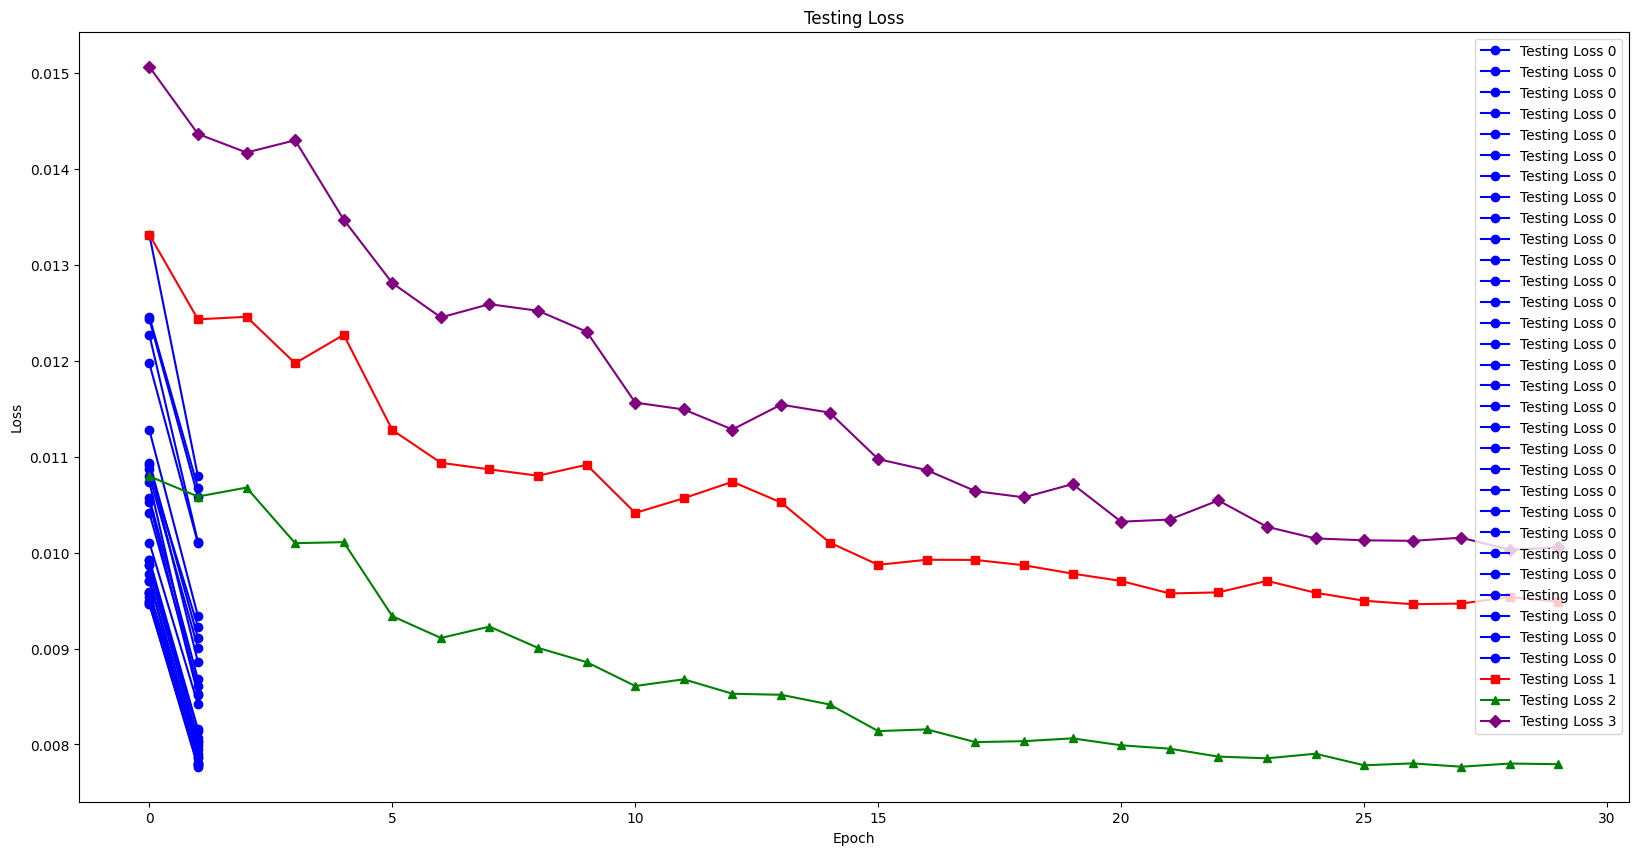

In [49]:
import matplotlib.pyplot as plt


plt.figure(figsize=(20, 10))

plt.plot(testing_loss, label='Testing Loss 0', color='blue', marker='o')

plt.plot(testing_loss[0], label='Testing Loss 1', color='red', marker='s')

plt.plot(testing_loss[1], label='Testing Loss 2', color='green', marker='^')

plt.plot(CRtesting_loss, label='Testing Loss 3', color='purple', marker='D')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Testing Loss')

plt.legend()
plt.show()

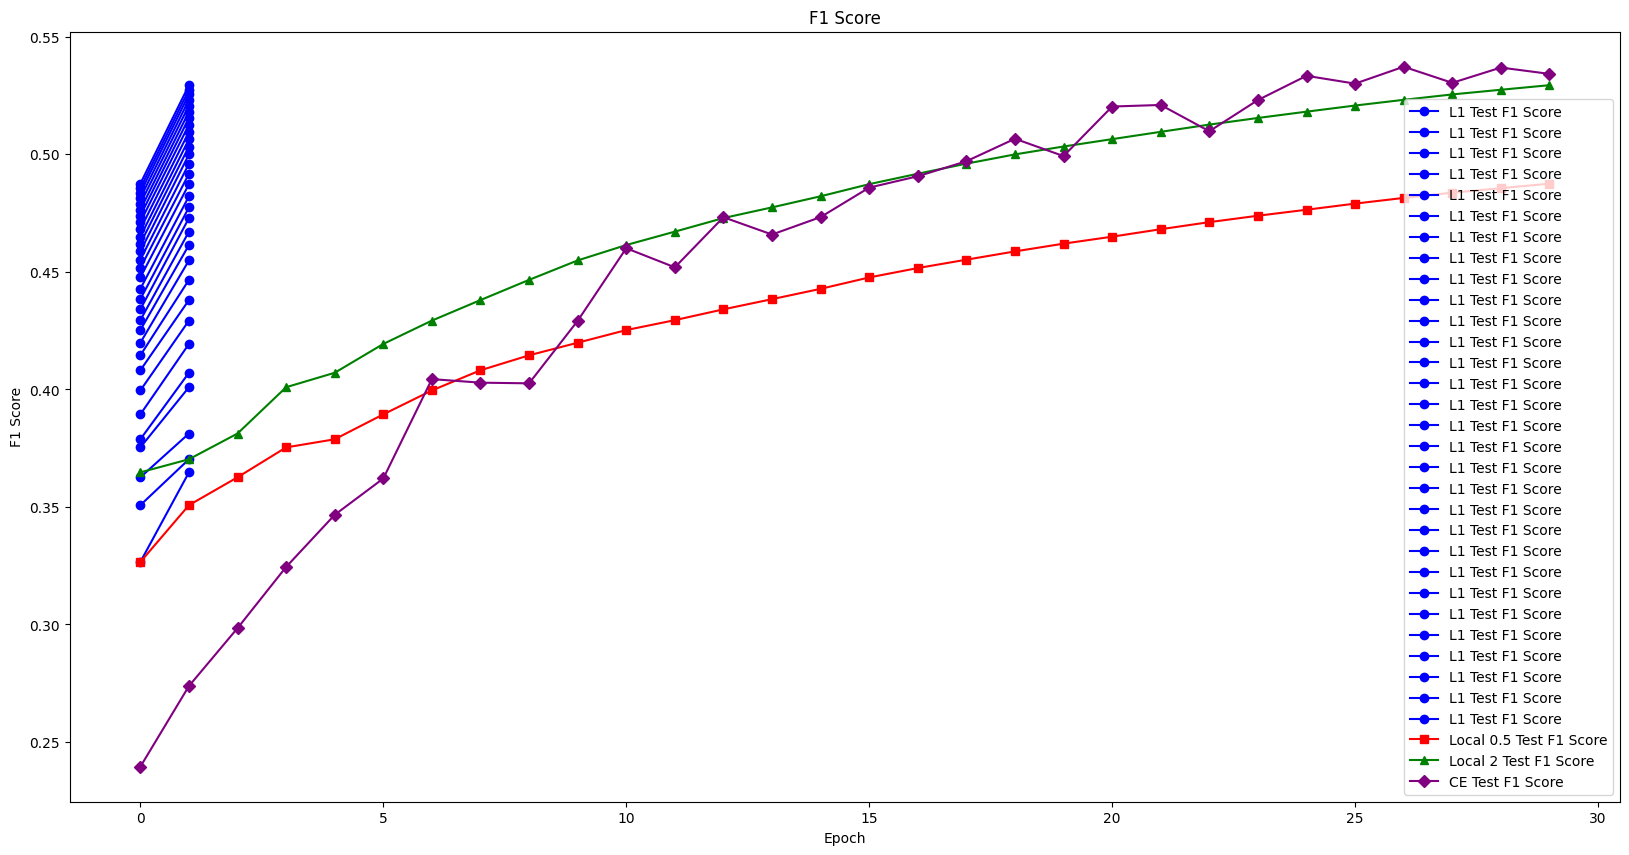

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(test_f1_scores, label='L1 Test F1 Score',color='blue', marker='o')
plt.plot(test_f1_scores[0],  label='Local 0.5 Test F1 Score', color='red', marker='s')
plt.plot(test_f1_scores[1], label='Local 2 Test F1 Score', color='green', marker='^')
plt.plot(CRtest_f1_scores, label='CE Test F1 Score', color='purple', marker='D')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score')
plt.legend()
plt.show()

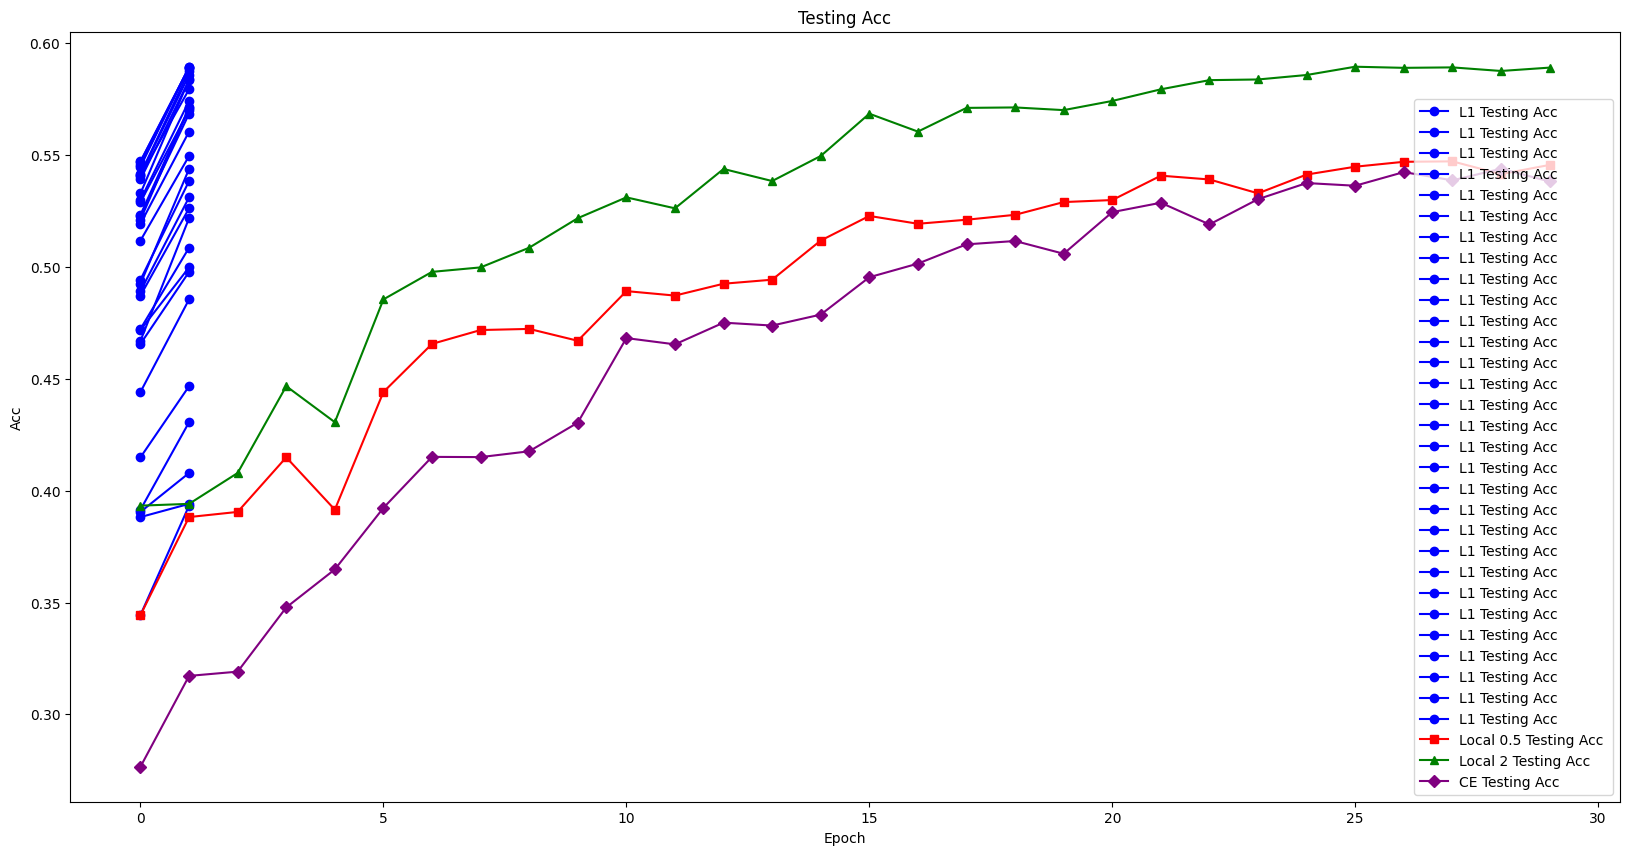

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(testing_acc, label='L1 Testing Acc ', color='blue', marker='o')
plt.plot(testing_acc[0], label='Local 0.5 Testing Acc ', color='red', marker='s')
plt.plot(testing_acc[1], label='Local 2 Testing Acc', color='green', marker='^')
plt.plot(CRtesting_acc, label='CE Testing Acc', color='purple', marker='D')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Testing Acc')
plt.legend()
plt.show()